In [1]:
import numpy as np
import gdal
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#merged slope raster, accumulation area raster, and watershed raster into one three band raster.
# exported this raster into a text file from OSGeo4W command line:
# gdal2xyz input.tif -band 1 -band 2 -band 3 output.txt. This is a slow operation... 


In [2]:
ds = gdal.Open('..\..\GIS\LIDAR\merge3.tif')


In [3]:
band1 = ds.GetRasterBand(1)
band2 = ds.GetRasterBand(2)
band3 = ds.GetRasterBand(3)

In [4]:
array1 = band1.ReadAsArray().flatten()
array2 = band2.ReadAsArray().flatten()
array3 = band3.ReadAsArray().flatten()

In [5]:
elderSlope = array2[array3 == 1]
elderArea = array1[array3 == 1]
foxSlope = array2[array3 == 2]
foxArea = array1[array3 == 2]
hankSlope = array2[array3 == 3]
hankArea = array1[array3 == 3]
drySlope = array2[array3 == 4]
dryArea = array1[array3 == 4]

#Band 1 = area
#Band 2 = slope
# Band 3 = watershed

#watershed key:
#Dry = 4
#Hank = 3
#Elder = 1
#Fox = 2

In [6]:
elderArea = elderArea + 1 #can't take log of 0
foxArea = foxArea + 1
hankArea = hankArea + 1 
dryArea = dryArea + 1 


In [101]:
np.add(bin_medians_dry,bin_stds_dry).shape

(20L,)

In [54]:
#GENERATE LOGARITHMIC BIN SPACING
numBins = 21

area_bins_elder = np.logspace(np.log10(min(elderArea)), np.log10(max(elderArea)), numBins)
area_bins_fox = np.logspace(np.log10(min(hankArea)), np.log10(max(hankArea)), numBins)
area_bins_hank = np.logspace(np.log10(min(hankArea)), np.log10(max(foxArea)), numBins)
area_bins_dry = np.logspace(np.log10(min(hankArea)), np.log10(max(dryArea)), numBins)


#Return the indices_elder of the bins to which each value in input array belongs.
indices_elder = np.digitize(elderArea, area_bins_elder)
indices_fox = np.digitize(foxArea, area_bins_fox)
indices_hank = np.digitize(hankArea, area_bins_hank)
indices_dry = np.digitize(dryArea, area_bins_dry)

#COMPUTE MEAN, MEDIAN AND STANDARD DEVIATION OF SLOPE IN EACH AREA BIN
bin_means_elder = [elderSlope[indices_elder == i].mean() for i in range(1, len(area_bins_elder))]
bin_medians_elder = [np.median(elderSlope[indices_elder == i]) for i in range(1, len(area_bins_elder))]
bin_stds_elder = [elderSlope[indices_elder == i].std() for i in range(1, len(area_bins_elder))]

bin_means_fox = [foxSlope[indices_fox == i].mean() for i in range(1, len(area_bins_fox))]
bin_medians_fox = [np.median(foxSlope[indices_fox == i]) for i in range(1, len(area_bins_fox))]
bin_stds_fox = [foxSlope[indices_fox == i].std() for i in range(1, len(area_bins_fox))]

bin_means_hank = [hankSlope[indices_hank == i].mean() for i in range(1, len(area_bins_hank))]
bin_medians_hank = [np.median(hankSlope[indices_hank == i]) for i in range(1, len(area_bins_hank))]
bin_stds_hank = [hankSlope[indices_hank == i].std() for i in range(1, len(area_bins_hank))]

bin_means_dry = [drySlope[indices_dry == i].mean() for i in range(1, len(area_bins_dry))]
bin_medians_dry = [np.median(drySlope[indices_dry == i]) for i in range(1, len(area_bins_dry))]
bin_stds_dry = [drySlope[indices_dry == i].std() for i in range(1, len(area_bins_dry))]



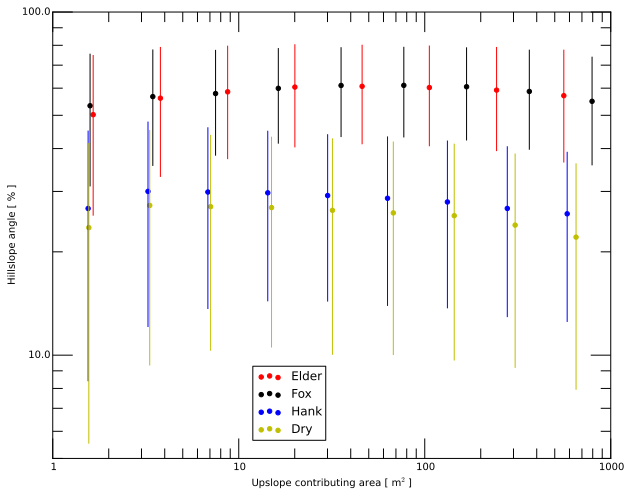

In [117]:
# Create a figure
plt.figure(figsize=(10,8))

plt.scatter(.5*(area_bins_elder[1:]+area_bins_elder[:-1]),bin_medians_elder, marker = "o", color = 'r', label="Elder")
plt.errorbar(.5*(area_bins_elder[1:]+area_bins_elder[:-1]),bin_medians_elder, yerr=bin_stds_elder, fmt = None, capthick=0, ecolor = 'r')

plt.scatter(.5*(area_bins_fox[1:]+area_bins_fox[:-1]),bin_medians_fox, marker = "o", color = 'k', label="Fox")
plt.errorbar(.5*(area_bins_fox[1:]+area_bins_fox[:-1]),bin_medians_fox, yerr=bin_stds_fox, fmt = None, capthick=0, ecolor = 'k')



plt.scatter(.5*(area_bins_hank[1:]+area_bins_hank[:-1]),bin_medians_hank, marker = "o", color = 'b', label="Hank")
plt.errorbar(.5*(area_bins_hank[1:]+area_bins_hank[:-1]),bin_medians_hank, yerr=bin_stds_hank, fmt = None, capthick=0, ecolor = 'b')

plt.scatter(.5*(area_bins_dry[1:]+area_bins_dry[:-1]),bin_medians_dry, marker = "o", color = 'y', label="Dry")
plt.errorbar(.5*(area_bins_dry[1:]+area_bins_dry[:-1]),bin_medians_dry, yerr=bin_stds_dry, fmt = None, capthick=0, ecolor = 'y')

#plt.fill_between(.5*(area_bins_elder[1:]+area_bins_elder[:-1]),np.subtract(bin_medians_elder, bin_stds_elder), np.add(bin_medians_elder,bin_stds_elder), color = 'r', alpha=0.3)
#plt.fill_between(.5*(area_bins_fox[1:]+area_bins_fox[:-1]),np.subtract(bin_medians_fox, bin_stds_fox), np.add(bin_medians_fox,bin_stds_fox), color = 'k', alpha=0.3)
#plt.fill_between(.5*(area_bins_hank[1:]+area_bins_hank[:-1]),np.subtract(bin_medians_hank, bin_stds_hank), np.add(bin_medians_hank,bin_stds_hank), color = 'b', alpha=0.3)
#plt.fill_between(.5*(area_bins_dry[1:]+area_bins_dry[:-1]),np.subtract(bin_medians_dry, bin_stds_dry), np.add(bin_medians_dry,bin_stds_dry), color = 'y', alpha=0.3)

plt.legend(bbox_to_anchor=(0.5, 0.22))
plt.ylabel("Hillslope angle [ % ]")
plt.xlabel("Upslope contributing area [ m$^2$]")
plt.ylim([5,100])
plt.xlim([1,1000])
plt.yscale('log')
plt.xscale('log')
ax = plt.gca()
import matplotlib.ticker
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params('both', length=20, width=1, which='major')
ax.tick_params('both', length=10, width=1, which='minor')
plt.savefig('logS_vs_logA.pdf', transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()